In [1]:
import polars as pl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# データ準備

## load data

In [2]:
df = pl.read_csv("HostLogons-demo.csv")
df = df.with_columns(pl.col("Date").str.strptime(pl.Date, fmt = "%m/%d/%Y"))
df.head()

Date,EventId,AccountNtdomain,ComputerName,logontype,TotalLogons
date,str,str,str,i64,i64
2018-01-03,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",10,2
2018-01-03,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",3,106
2018-01-03,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",4,68
2018-01-04,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",3,53
2018-01-04,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",4,89


## data preprocessing

In [3]:
tmp = df.groupby("Date").agg([pl.col("TotalLogons").sum().alias("n_events")]).sort("Date")

In [4]:
tmp.head()

Date,n_events
date,i64
2018-01-03,176
2018-01-04,142
2018-01-05,85
2018-01-06,147
2018-01-07,142


## plot date

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f74cw8ru because the default path (/home/work/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<Axes: xlabel='Date', ylabel='n_events'>

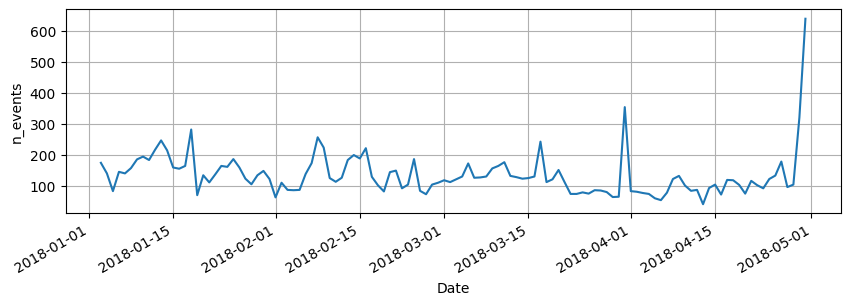

In [6]:
plt.rcParams["figure.figsize"] = (10,3)

plt.grid()
plt.gcf().autofmt_xdate()
sns.lineplot(tmp, x = "Date", y= "n_events", legend="full")

## データ基本調査

### 標本自己相関

(0.0, 40.5)

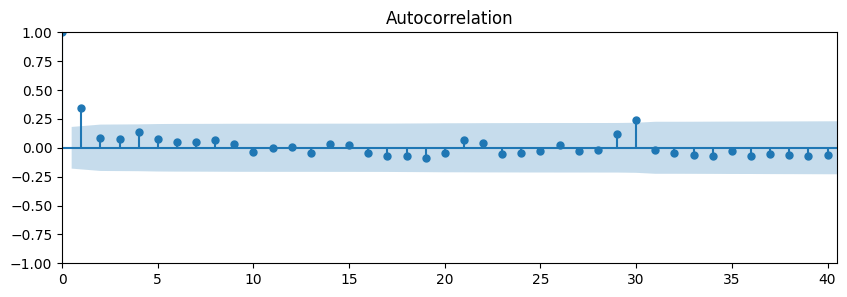

In [7]:
plot_acf(tmp.get_column("n_events").to_numpy(), missing = "drop", lags=40);
plt.xlim((0.0, 40.5))

### 標本偏自己相関

/home/work/.cache/pypoetry/virtualenvs/godaddy-3UyvmeC2-py3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(0.0, 40.5)

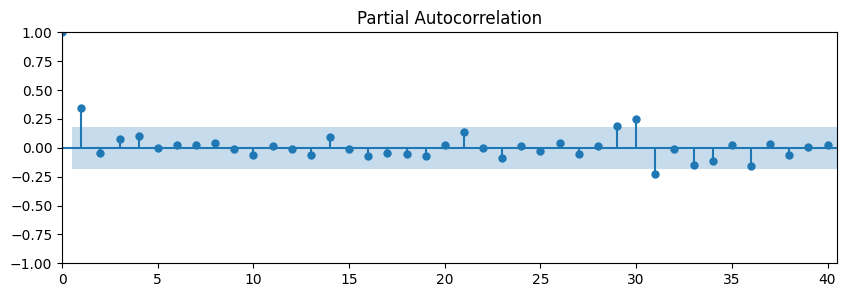

In [8]:
plot_pacf(tmp.get_column("n_events").to_numpy(), lags=40);
plt.xlim((0.0, 40.5))

# model

## prophet (multiplicative)

### 学習

In [9]:
from prophet import Prophet
from prophet.plot import plot_components

In [10]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    seasonality_mode= "multiplicative",
    interval_width=0.98,
    changepoint_range = 0.8,
)

model.add_seasonality(
    name = "monthly",
    period = 30.5,
    fourier_order = 5
)
model = model.fit(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast = model.predict(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast["fact"] = tmp.get_column("n_events").to_list()

02:36:05 - cmdstanpy - INFO - Chain [1] start processing
02:36:05 - cmdstanpy - INFO - Chain [1] done processing


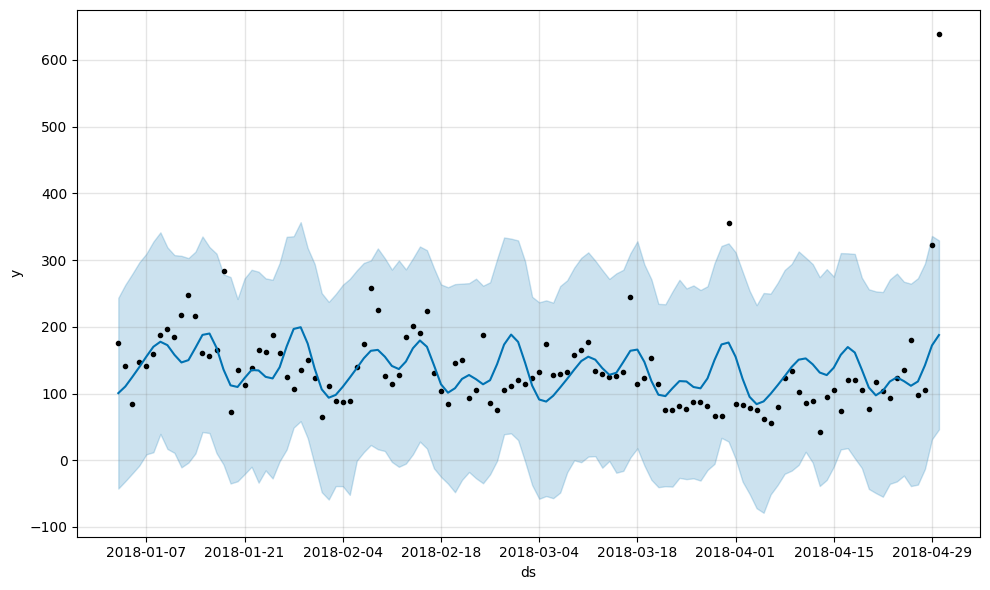

In [11]:
model.plot(forecast);

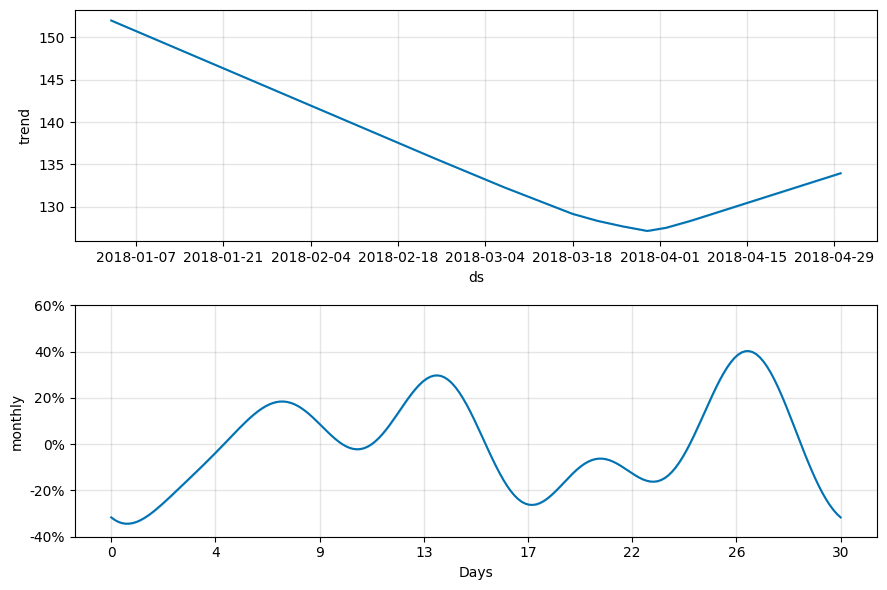

In [12]:
plot_components(model, forecast);

### 解析

In [13]:
forecasted = pl.from_pandas(forecast)
forecasted = forecasted.with_columns(pl.col("ds").cast(pl.Date))

In [14]:
forecasted.head()

ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,fact
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2018-01-03,151.981677,-42.450413,243.506157,151.981677,151.981677,-0.338071,-0.338071,-0.338071,-0.338071,-0.338071,-0.338071,0.0,0.0,0.0,100.601101,176
2018-01-04,151.667921,-31.387648,263.087181,151.667921,151.667921,-0.270986,-0.270986,-0.270986,-0.270986,-0.270986,-0.270986,0.0,0.0,0.0,110.567986,142
2018-01-05,151.354165,-19.778893,279.469271,151.354165,151.354165,-0.174899,-0.174899,-0.174899,-0.174899,-0.174899,-0.174899,0.0,0.0,0.0,124.882443,85
2018-01-06,151.040409,-7.895925,296.708217,151.040409,151.040409,-0.074968,-0.074968,-0.074968,-0.074968,-0.074968,-0.074968,0.0,0.0,0.0,139.717156,147
2018-01-07,150.726653,8.891743,309.564466,150.726653,150.726653,0.030923,0.030923,0.030923,0.030923,0.030923,0.030923,0.0,0.0,0.0,155.387621,142


In [15]:
forecasted.with_columns(
    [
        # pl.when(pl.col("fact") > pl.col("yhat_upper"))
        pl.when(pl.col("fact").is_between(pl.col("yhat_lower"), pl.col("yhat_upper")))
        .then(0).otherwise(1).alias("is_abnormal")
    ]
).filter(pl.col("is_abnormal") == 1)

/home/work/.cache/pypoetry/virtualenvs/godaddy-3UyvmeC2-py3.9/lib/python3.9/site-packages/polars/internals/expr/expr.py:3497: FutureWarning: Default behaviour will change from excluding both bounds to including both bounds. Provide a value for the `closed` argument to silence this warning.
  warnings.warn(


ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,fact,is_abnormal
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i32
2018-01-18,147.275337,-6.518075,278.670444,147.275337,147.275337,-0.076656,-0.076656,-0.076656,-0.076656,-0.076656,-0.076656,0.0,0.0,0.0,135.985779,283,1
2018-03-31,127.261021,28.046891,325.149262,127.261021,127.261021,0.386514,0.386514,0.386514,0.386514,0.386514,0.386514,0.0,0.0,0.0,176.449128,355,1
2018-04-30,133.949461,46.228859,329.503957,133.949461,133.949461,0.40124,0.40124,0.40124,0.40124,0.40124,0.40124,0.0,0.0,0.0,187.695326,639,1


### 推定誤差 (MSE)

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true = forecasted.get_column("fact"), y_pred = forecasted.get_column("yhat"))

4127.8196016163765

## prophet (multiplicative)

In [17]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    seasonality_mode= "additive",
    interval_width=0.99,
    changepoint_range = 0.8,
)

model.add_seasonality(
    name = "monthly",
    period = 30.5,
    fourier_order = 5
)
model = model.fit(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast = model.predict(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast["fact"] = tmp.get_column("n_events").to_list()

02:36:05 - cmdstanpy - INFO - Chain [1] start processing
02:36:05 - cmdstanpy - INFO - Chain [1] done processing


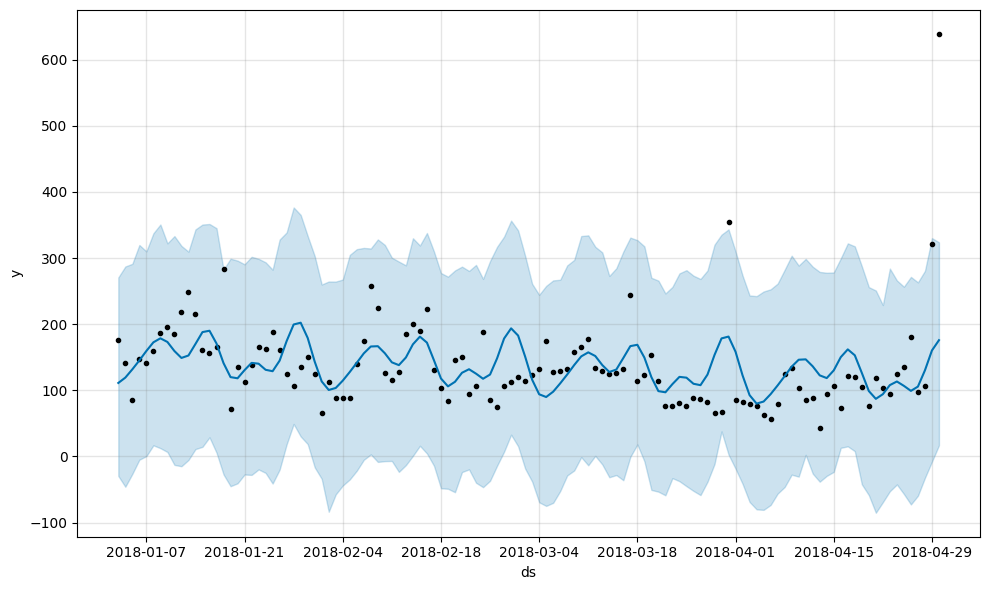

In [18]:
model.plot(forecast);

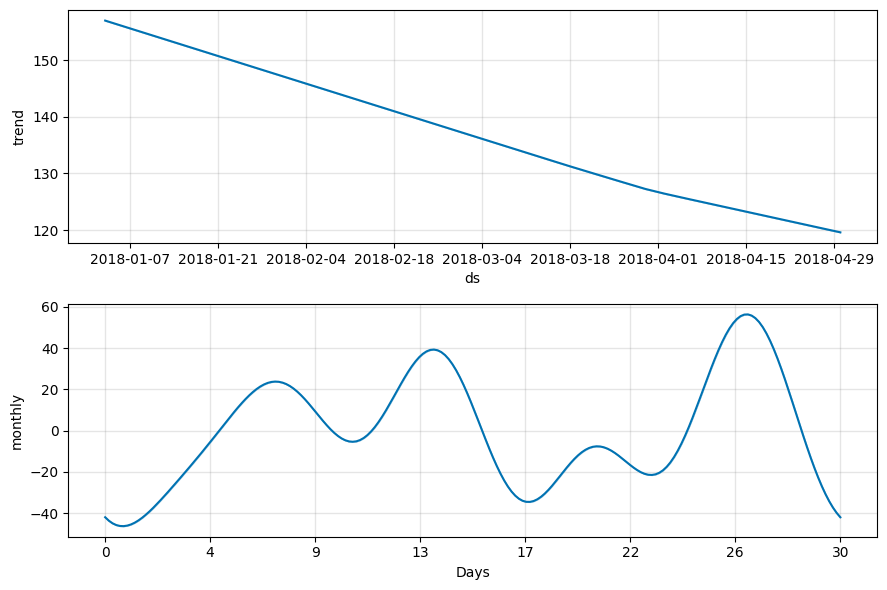

In [19]:
from prophet.plot import plot_components
plot_components(model, forecast);

### 推定誤差 (MSE)

In [20]:
from sklearn.metrics import mean_squared_error
forecasted = pl.from_pandas(forecast)
forecasted = forecasted.with_columns(pl.col("ds").cast(pl.Date))
mean_squared_error(y_true = forecasted.get_column("fact"), y_pred = forecasted.get_column("yhat"))

4183.717950278558

## prophet (multipliciative: wrong interval)

In [21]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    seasonality_mode= "multiplicative",
    interval_width=0.98,
    changepoint_range = 0.8,
)

model.add_seasonality(
    name = "monthly",
    period = 7,
    fourier_order = 5
)
model = model.fit(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast = model.predict(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast["fact"] = tmp.get_column("n_events").to_list()

02:36:05 - cmdstanpy - INFO - Chain [1] start processing
02:36:05 - cmdstanpy - INFO - Chain [1] done processing


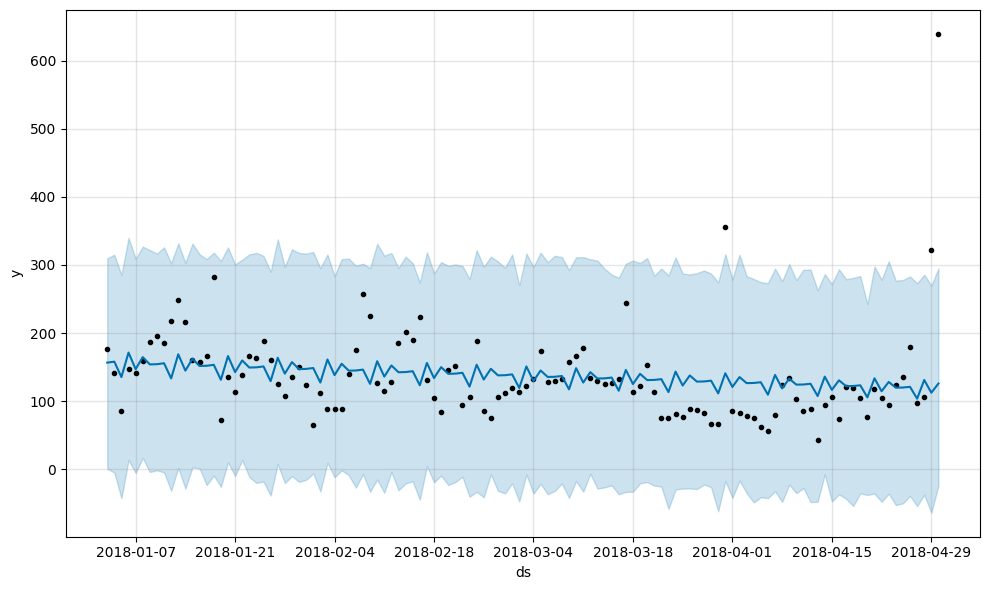

In [22]:
model.plot(forecast);

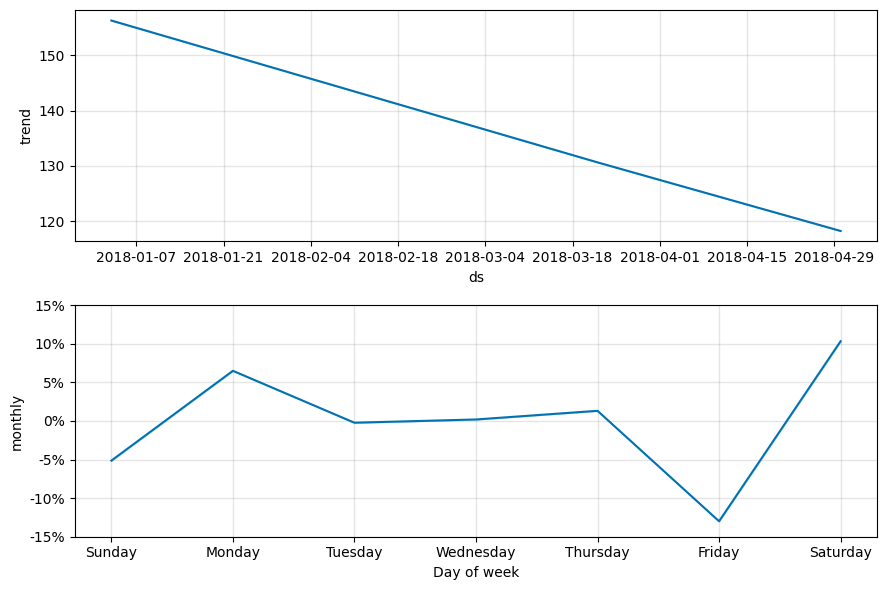

In [23]:
plot_components(model, forecast);

In [24]:
from sklearn.metrics import mean_squared_error
forecasted = pl.from_pandas(forecast)
forecasted = forecasted.with_columns(pl.col("ds").cast(pl.Date))
mean_squared_error(y_true = forecasted.get_column("fact"), y_pred = forecasted.get_column("yhat"))

4822.346556815958

## prophetに関するインターバルの最適調査

In [25]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [26]:
def calc_MSE_per_interval(interval):
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        seasonality_mode= "multiplicative",
        interval_width=0.98,
        changepoint_range = 0.8
    )

    model.add_seasonality(
        name = "monthly",
        period = interval,
        fourier_order = 5
    )
    model = model.fit(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
    forecast = model.predict(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
    forecast["fact"] = tmp.get_column("n_events").to_list()
    forecasted = pl.from_pandas(forecast)
    forecasted = forecasted.with_columns(pl.col("ds").cast(pl.Date))
    return mean_squared_error(y_true = forecasted.get_column("fact"), y_pred = forecasted.get_column("yhat"))

In [27]:
vals = []
idxs = []
for i in range(1, 40):
    idxs.append(i)    
    vals.append(calc_MSE_per_interval(i))

02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1]

In [29]:
df = pl.DataFrame({"interval": idxs, "MSE": vals})
df.sort("MSE")

interval,MSE
i64,f64
27,3545.197111
15,3755.832768
37,3929.082287
30,3932.120651
25,4001.024735
36,4079.761501
26,4211.034174
31,4241.553099
29,4257.138731


## 複数のインターバルが設定された場合の調査

In [35]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    seasonality_mode= "additive",
    interval_width=0.98,
    changepoint_range = 0.8
)

model.add_seasonality(
    name = "half_monthly",
    period = 15,
    fourier_order = 5
)
model.add_seasonality(
    name = "monthly",
    period = 30,
    fourier_order = 5
)
model = model.fit(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast = model.predict(tmp.select([pl.col("Date").alias("ds"), pl.col("n_events").alias("y")]).to_pandas())
forecast["fact"] = tmp.get_column("n_events").to_list()
forecasted = pl.from_pandas(forecast)
forecasted = forecasted.with_columns(pl.col("ds").cast(pl.Date))
print(mean_squared_error(y_true = forecasted.get_column("fact"), y_pred = forecasted.get_column("yhat")))

02:41:07 - cmdstanpy - INFO - Chain [1] start processing
02:41:07 - cmdstanpy - INFO - Chain [1] done processing


3621.4892271174094


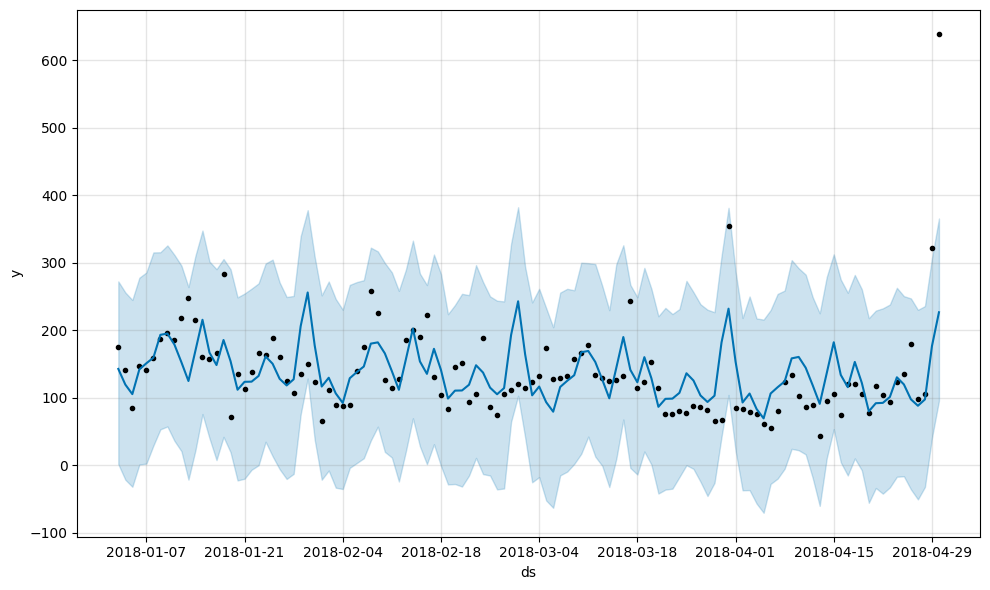

In [36]:
model.plot(forecast);

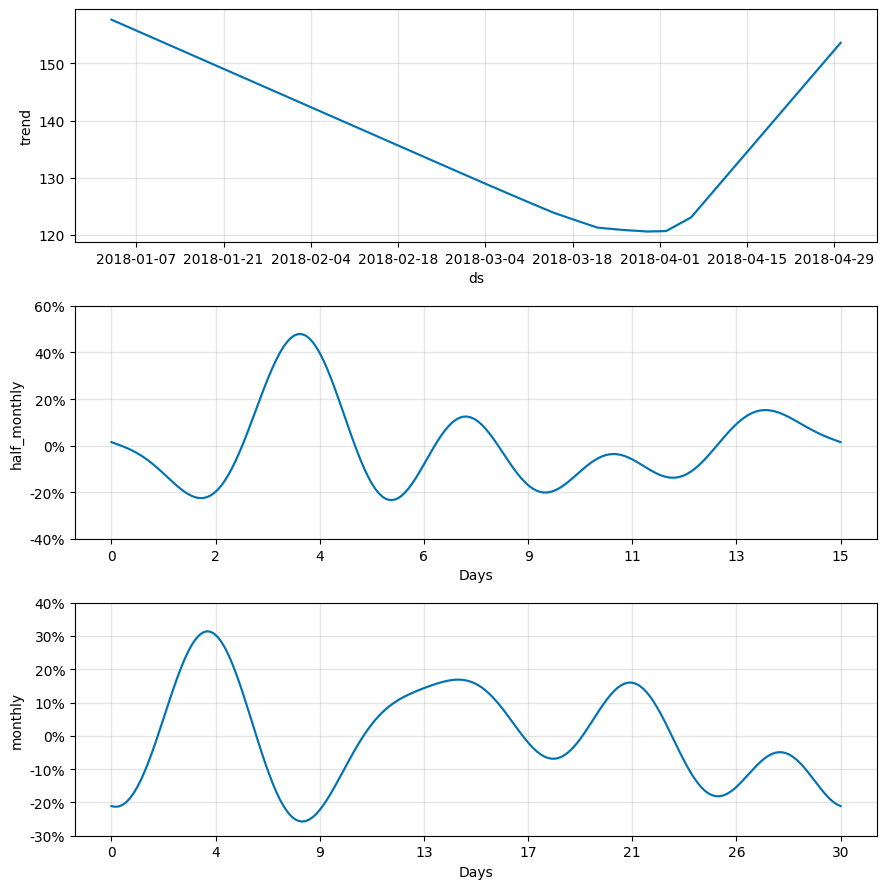

In [34]:
plot_components(model, forecast);